<a href="https://colab.research.google.com/github/DaniilAszn/ML2_course/blob/main/5_%D0%A3%D0%B4%D0%B0%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D1%88%D1%83%D0%BC%D0%B0_%D0%B8_%D0%B3%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D1%8F_%D0%BE%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%BE%D0%B2_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_AE_%D0%B8_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **5 практика по NN by RTU MIREA**

## **Часть 1: Реализация автоенкодера. Удаление шума из данных.**

## Шаг 0: Подготовка датасета

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [ ]:
# Загрузка датасета STL10
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 2640397119/2640397119 [03:41<00:00, 11912408.75it/s]


Extracting ./data/stl10_binary.tar.gz to ./data


## Шаг 1: Построение AE

In [ ]:
# Модель автоенкодера, который удаляет шум
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Часть: Енкодер
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        # Часть: Декодер
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    # Прямой проход: енкодер -> декодер
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = DenoisingAutoencoder()

## Шаг 2: Обучение


In [ ]:
# MSE'шка и оптимизатор
loss_f = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение автоенкодера
loss_list = []
NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    for data in train_loader:
        inputs, _ = data
        noisy_inputs = inputs + 0.1 * torch.randn_like(inputs) # добавляем шум во время обучения
        outputs = model(noisy_inputs)
        loss = loss_f(outputs, inputs)

        optimizer.zero_grad() # делаем, чтоб не добавлял градиенты с прошлой
                              # итерации
        loss.backward() # обратный проход: вычисляем градиенты для
                              # обновления весов
        optimizer.step() # обновление весов

    loss_list.append(loss.log().item())
    print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}], loss: {loss.item()}')

Epoch [1/10], loss: 0.020793559029698372
Epoch [2/10], loss: 0.00798886176198721
Epoch [3/10], loss: 0.007870884612202644
Epoch [4/10], loss: 0.004628796596080065
Epoch [5/10], loss: 0.005380549002438784
Epoch [6/10], loss: 0.006008749827742577
Epoch [7/10], loss: 0.0042609344236552715
Epoch [8/10], loss: 0.0058144982904195786
Epoch [9/10], loss: 0.004826270509511232
Epoch [10/10], loss: 0.003587058512493968


## Шаг 3: Визуализация результатов



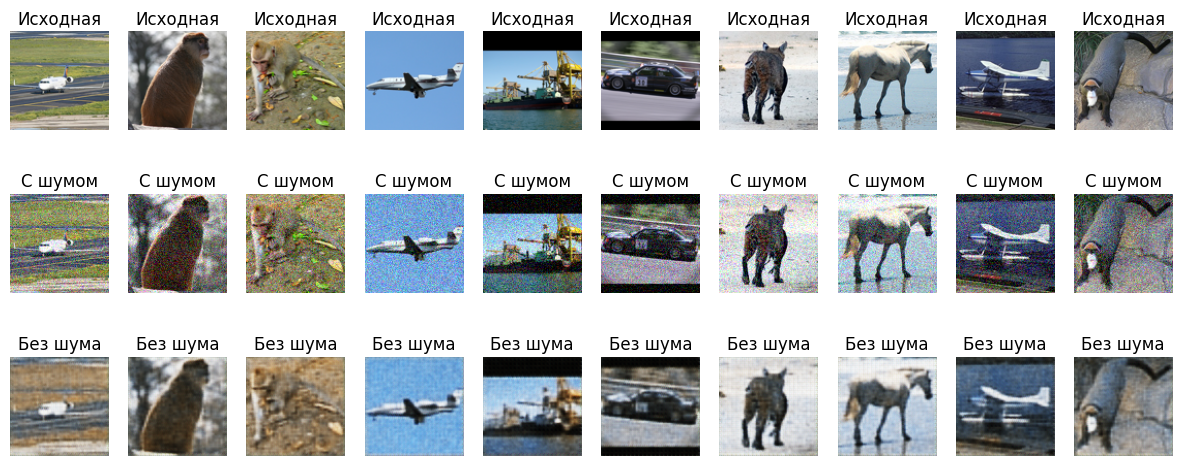

In [ ]:
# Демонстрация результатов
NOISE = 0.1
data_iter = iter(train_loader)
images, labels = next(data_iter)
noisy_images = images + NOISE * torch.randn_like(images)
reconstructed_images = model(noisy_images)

# визуализация картинок: исходные, с шумом, очищеннные от шума
fig, axis = plt.subplots(3, 10, figsize=(15, 6))
for i in range(10):
    axis[0][i].imshow(images[i].permute(1, 2, 0))
    axis[0][i].axis('off')
    axis[0][i].set_title('Исходная')

    axis[1][i].imshow(noisy_images[i].permute(1, 2, 0))
    axis[1][i].axis('off')
    axis[1][i].set_title('С шумом')

    axis[2][i].imshow(reconstructed_images[i].detach().permute(1, 2, 0))
    axis[2][i].axis('off')
    axis[2][i].set_title('Без шума')

plt.show()

## **Часть 2: Реализация вариационного автоенкодера. Генерация новых объектов.**

## Шаг 0: Подготовка датасета

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
plt.rcParams['figure.dpi'] = 200

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Загрузка датасета
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
        transform=torchvision.transforms.ToTensor(),
        download=True),
        batch_size=128,
        shuffle=True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 171075157.57it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 47355626.98it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 47565244.34it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 7641608.01it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Шаг 1: Построение VAE

In [ ]:
# Реализация VAE
class Encoder(nn.Module):
    def __init__(self,
                 latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda()
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (- 1 / 2) * (1 + torch.log(sigma ** 2) - sigma ** 2 - mu ** 2).sum()
        return z


class Decoder(nn.Module):
    def __init__(self,
                 latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))


class VariationalAutoencoder(nn.Module):
    def __init__(self,
                 latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

## Шаг 2: Обучение


In [ ]:
# Обучение VAE
def train(autoencoder, data, epochs=10):
    opt = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat) ** 2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [ ]:
latent_dims = 2
vae = VariationalAutoencoder(latent_dims).to(device)
vae = train(vae, data)

## Шаг 3: Визуализация результатов



In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n * w, n * w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n - 1 - i) * w:(n - 1 - i + 1) * w, j * w:(j + 1) * w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

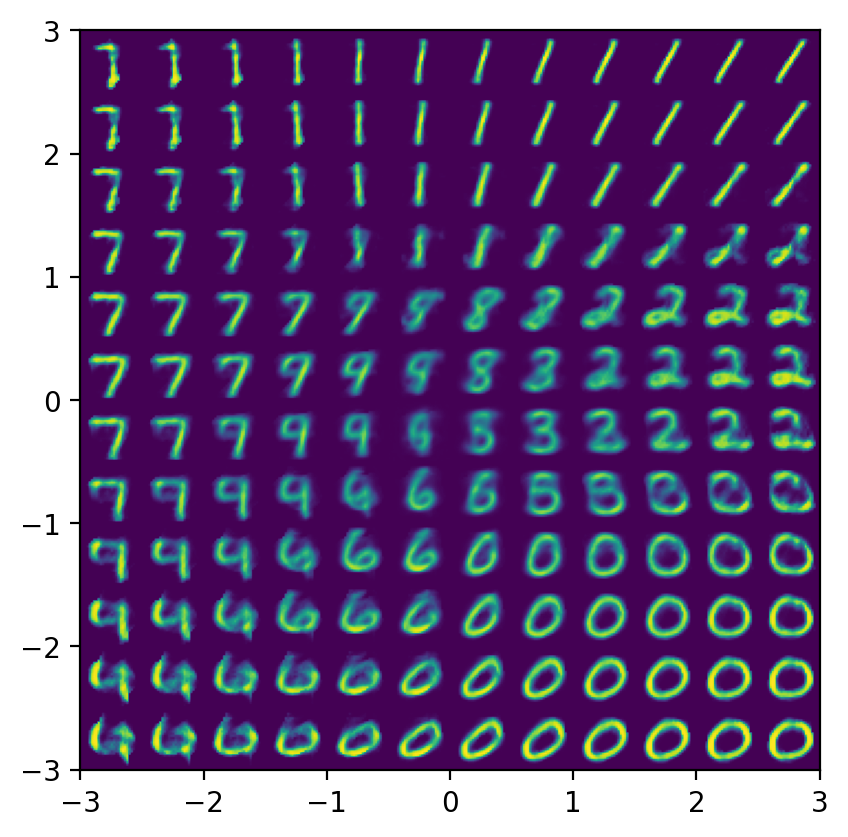

In [ ]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))